# Import Modules

In [1]:
!git clone https://github.com/m-zayan/notebooks.git

!mv ./notebooks/utils ./utils
!rm -r notebooks

Cloning into 'notebooks'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 4), reused 26 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams as mparms

from tqdm.notebook import tqdm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

from tensorflow.keras import backend as K

plt.style.use('grayscale')

In [3]:
from utils.test_utils import test_plots

from utils.metrics import mean_average_precision as mPA
from utils.plot_utils import plot_random, plot, plot_latent, grid_plot

from utils.random import random_indices, gaussian_noise

In [4]:
mparms['font.size'] = 16

mparms['figure.facecolor'] = 'gray'

mparms['text.color'] = 'black'

# Test

11493376/11490434 [==============================] - 0s 0us/step


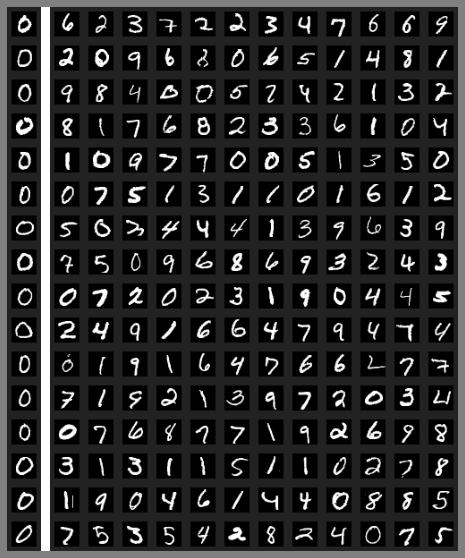

In [5]:
test_plots.test_grid_plot_mnist()

# Load Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train[..., None], x_test[..., None]

[x_train, x_test, y_train, y_test] = map(lambda arr: arr.astype('float32'), [x_train, x_test, y_train, y_test])

sigma = 1.0
mean = 0.0

noisy_x_train = gaussian_noise(x_train / 128.0, mean, sigma, random_state=42)
noisy_x_test =  gaussian_noise(x_test / 128.0, mean, sigma, random_state=42)

m_train = len(x_train)
m_test = len(x_test)

C_SHAPE = x_train.shape[1:]

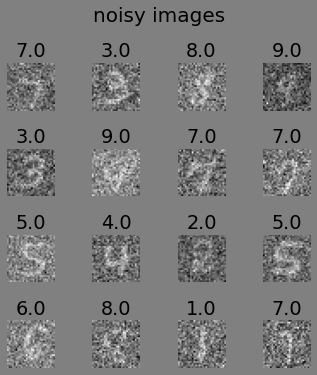

In [7]:
fig = plot_random(noisy_x_train, y_train, nrows=4, ncols=4, figsize=(5, 5), random_state=42)

fig.suptitle('noisy images', x=0.5, y=1.05, fontsize=20)
fig.tight_layout()

# Model

In [8]:
def conv_block(block_num, inputs, filters, strides=[1, 1], kernel_size=(3, 3), 
               activation=['relu', 'relu'], padding=['valid', 'valid'], pool_size=(3, 3)):
 
 
  if not isinstance(filters, list):
    
    filters = [filters, filters]

  x = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides[0], activation=activation[0], padding=padding[0], name = f'conv2d_{block_num}')(inputs)
  x = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides[1], activation=activation[1], padding=padding[1], name = f'conv2d_{block_num}{block_num}')(x)

  if pool_size is not None:

    x = MaxPool2D(pool_size=pool_size, name=f'max_pool2d_{block_num}')(x)

  return x

def deconv_block(block_num, inputs, filters=32, kernel_size=(3, 3), 
               activation=['relu', 'relu'], padding=['valid', 'valid'], strides=[1, 1], upsample=(3, 3), kernel_regularizer=None):
  
  if not isinstance(filters, list):
  
    filters = [filters, filters]

 
  x = Conv2DTranspose(filters=filters[0], kernel_size=kernel_size, strides=strides[0], activation=activation[0], padding=padding[0], name = f'conv2dT_{block_num}')(inputs)
  x = Conv2DTranspose(filters=filters[1], kernel_size=kernel_size, strides=strides[1], kernel_regularizer=kernel_regularizer, activation=activation[1], padding=padding[1], name = f'conv2dT_{block_num}{block_num}')(x)

  if upsample is not None:

    x = UpSampling2D(size=upsample, name=f'upsample2d_{block_num}')(x)

  return x

In [9]:
def reconstruction_loss(x, x_pred):

  loss = 0.5 * K.mean((x_pred - x) ** 2)
  
  return loss

In [10]:
K.clear_session()

inputs = Input(shape=(28, 28, 1))

x0 = conv_block(1, inputs, filters=[32, 64], kernel_size=(3, 3), activation=['relu', 'relu'], 
               padding=['valid', 'valid'], strides=[2, 2], pool_size=None)

x0 = BatchNormalization(axis=[3])(x0)

z = Conv2D(filters=1, kernel_size=(3, 3), padding='same', name='latent')(x0)

x2 = deconv_block(1, z, filters=[64, 32], kernel_size=(3, 3), strides=[2, 2], activation=['relu', 'relu'], upsample=None)

outputs = Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=1, name='output')(x2)

model = Model(inputs=inputs, outputs=[outputs, z])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 64)          256       
_________________________________________________________________
latent (Conv2D)              (None, 6, 6, 1)           577       
_________________________________________________________________
conv2dT_1 (Conv2DTranspose)  (None, 13, 13, 64)        640       
_________________________________________________________________
conv2dT_11 (Conv2DTranspose) (None, 27, 27, 32)       

In [11]:
K.clear_session()

CLR = [tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.05, patience=2)]
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(optimizer=opt, loss=[reconstruction_loss])

history = model.fit(noisy_x_train, x_train, epochs=25, callbacks=CLR)

Epoch 1/25
1875/1875 [==============================] - 5s 3ms/step - loss: 930.2836 - output_loss: 930.2836
Epoch 2/25
1875/1875 [==============================] - 5s 3ms/step - loss: 828.1235 - output_loss: 828.1235
Epoch 3/25
1875/1875 [==============================] - 5s 3ms/step - loss: 799.7852 - output_loss: 799.7852
Epoch 4/25
1875/1875 [==============================] - 5s 3ms/step - loss: 783.3987 - output_loss: 783.3987
Epoch 5/25
1875/1875 [==============================] - 5s 3ms/step - loss: 776.0740 - output_loss: 776.0740
Epoch 6/25
1875/1875 [==============================] - 5s 3ms/step - loss: 771.2531 - output_loss: 771.2531
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 767.0375 - output_loss: 767.0375
Epoch 8/25
1875/1875 [==============================] - 5s 3ms/step - loss: 763.0616 - output_loss: 763.0616
Epoch 9/25
1875/1875 [==============================] - 5s 3ms/step - loss: 758.4677 - output_loss: 758.4677
Epoch 10/25
1875/18

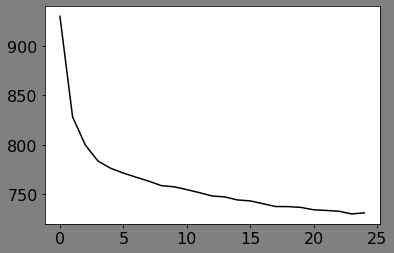

In [12]:
loss = history.history['loss']
epoch = history.epoch

plt.plot(epoch, loss)
plt.savefig('model_loss.png')
plt.show()

# Results

In [13]:
sample_size = 16

indices = random_indices(n=sample_size, start=1, end=sample_size + 1, step=1, replace=False, random_state=42)

sample_x = noisy_x_test[indices]
sample_y = y_test[indices].astype('int')

# predict
sample_gen, sample_latent = model.predict(sample_x)

# concat
sx = np.concatenate([sample_x, sample_gen, x_test[indices]], axis=0)
sy = np.concatenate([sample_y, sample_y, sample_y])

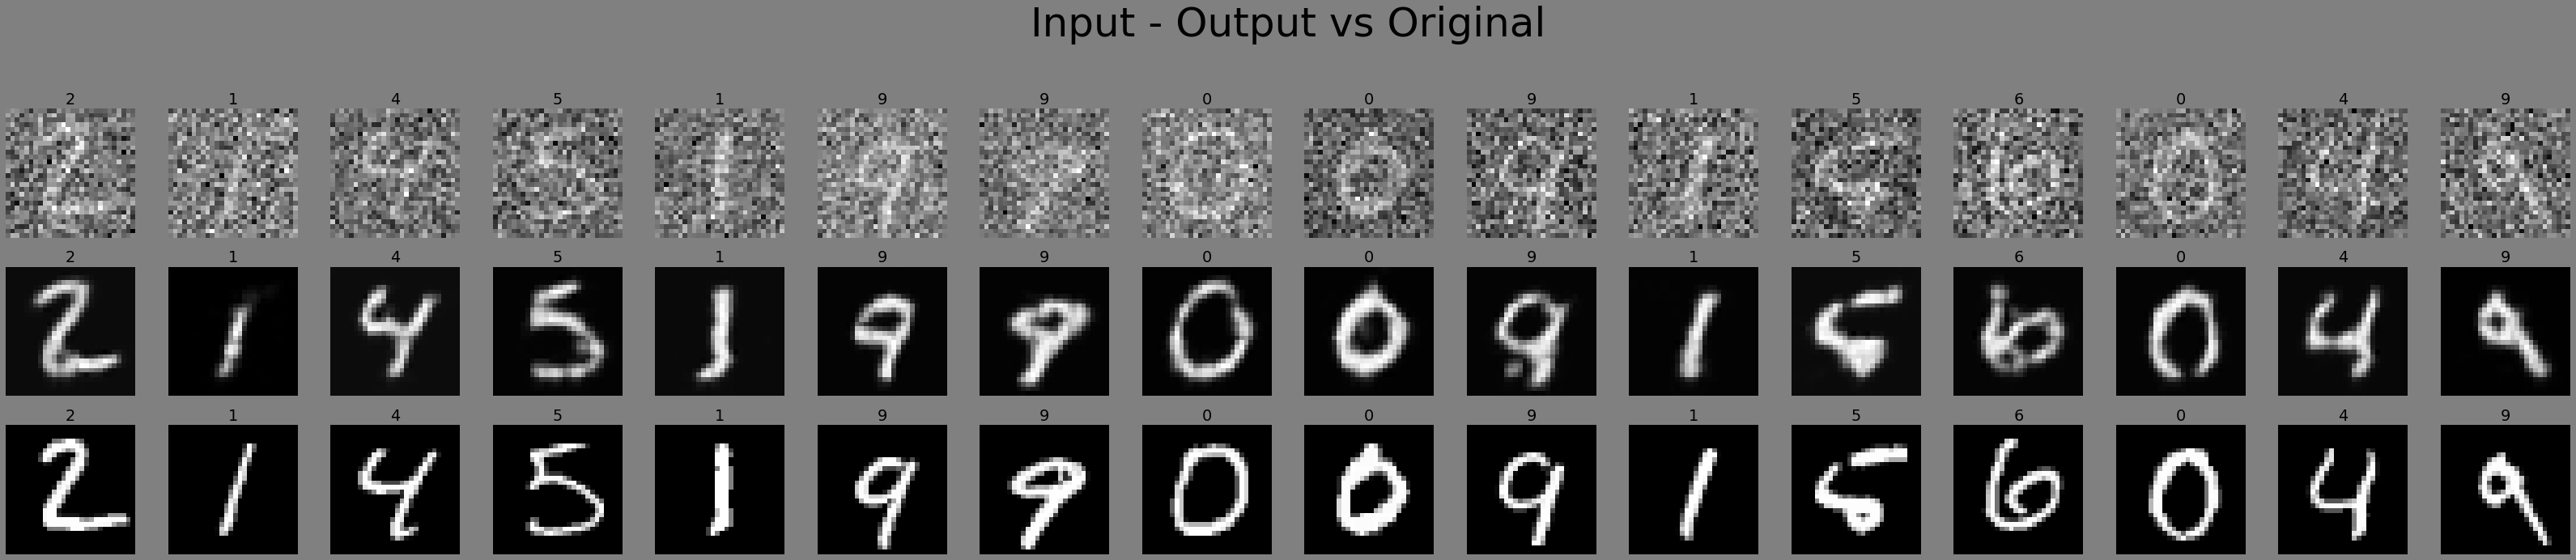

In [30]:
fig = plot(sx, sy, nrows=3, ncols=16)

fig.suptitle('Input - Output vs Original', x=0.5, y=1.15, fontsize=50)
fig.tight_layout()

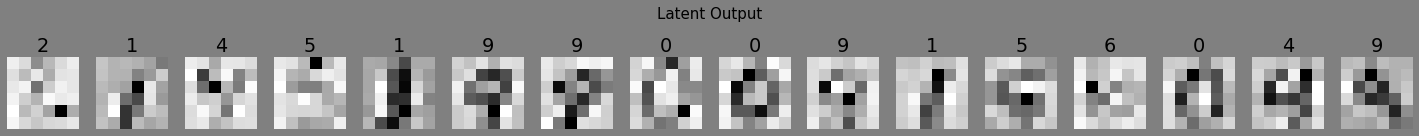

In [15]:
fig = plot(sample_latent, sample_y, nrows=1, ncols=16, figsize=(20, 6))
fig.suptitle('Latent Output', x=0.5, y=0.7, fontsize=15)
fig.tight_layout()

# Image Retrieval

In [16]:
# intermediate layer model (encoder)

zx = model.get_layer('latent').output

encoder = Model(inputs=model.input, outputs=zx)
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 64)          256       
_________________________________________________________________
latent (Conv2D)              (None, 6, 6, 1)           577       
Total params: 19,649
Trainable params: 19,521
Non-trainable params: 128
_________________________________________________________________


In [17]:
xtest_latent = encoder.predict(x_test)
latent = xtest_latent.reshape(len(xtest_latent), -1)

shape = latent.shape

print(shape)

(10000, 36)


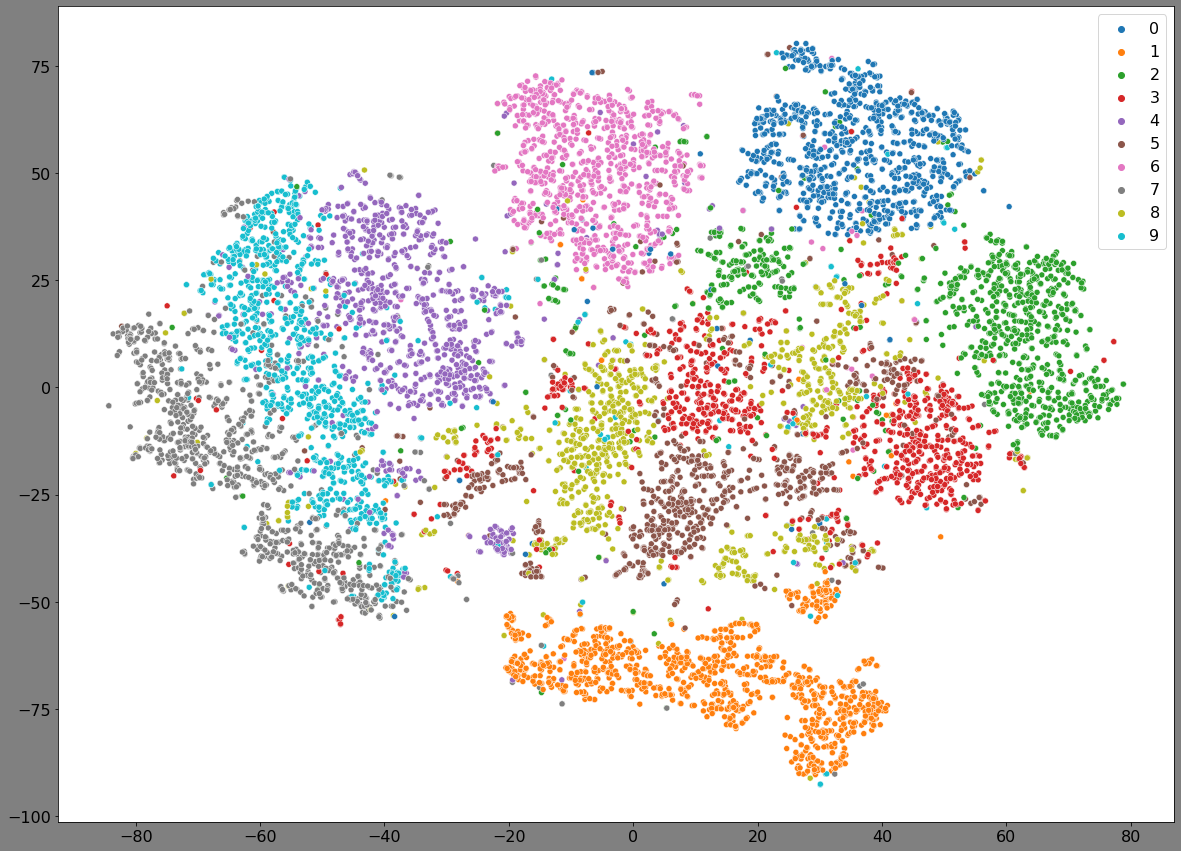

In [18]:
# Latent (2d Projection)

fig = plot_latent(latent, labels=y_test.astype('int'), n_iter=1000, figsize=(20, 15))
fig.savefig('latent.png')

In [19]:
def nd_get_nearest(dist, n):

  result = []

  for d in dist:

    nearest = []

    for i in range(len(d)):

      nearest.append((d[i], i))

    nearest.sort()

    indices = [i[1] for i in nearest[:n]]

    result.append(indices)
  
  result = np.array(result)

  return result
  
def get_nearest(dist, n):

  nearest = []

  for i in range(len(dist)):

    nearest.append((dist[i], i))

  nearest.sort()

  indices = [i[1] for i in nearest[:n]]

  return indices, nearest

In [20]:
dist = []

for i in tqdm(range(len(latent))):

  d = np.linalg.norm(latent - latent[i], axis=-1)
  d[i] = np.inf

  dist.append(d)

dist = np.array(dist)

print(dist.shape)


(10000, 10000)


In [21]:
indices = random_indices(10, 0, m_test, random_state=42)
n_neighbours = 16

idx = nd_get_nearest(dist[indices], n=n_neighbours)

sample_in = x_test[indices]
sample_out = []

for i in range(len(idx)):

  sample_out.append(x_test[idx[i]])


sample_out = np.array(sample_out).reshape(160, 28, 28, 1)

print(sample_out.shape)

(160, 28, 28, 1)


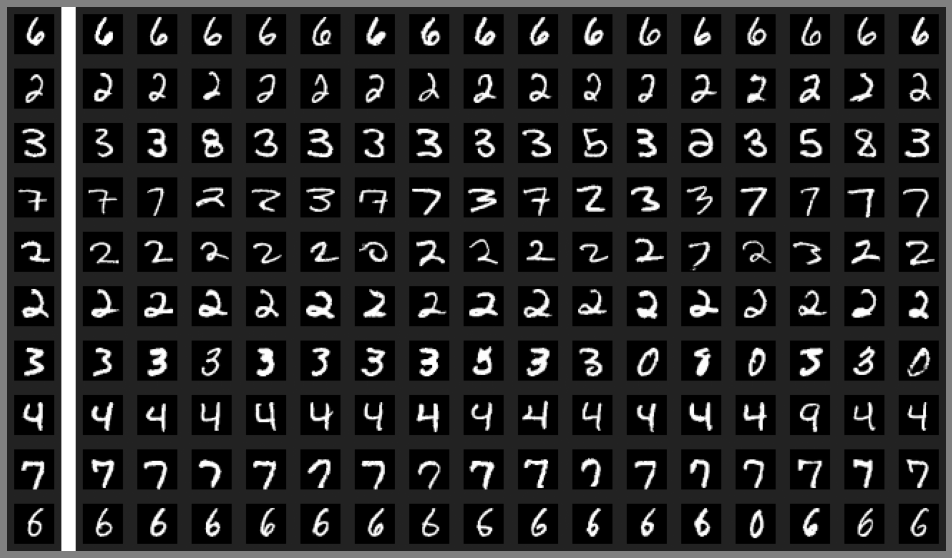

In [22]:
grid_plot(sample_out, nrows=10, ncols=16, ground_truth=sample_in)

plt.savefig('query.png')

In [23]:
y_unique = np.unique(y_test, return_counts=True)

map_label_idx = {key: value for key, value in zip(y_unique[0], y_unique[1])}

metrice_test = []
counts_test = []

unique_counts = []
p_test = []
y_true = []

for i in tqdm(range(m_test)):

  true = y_test[i]
  counts = map_label_idx[true]

  counts_test.append(counts)

  indices, _ = get_nearest(dist[i], n=counts)

  acc = (y_test[indices] == true).sum()
  metrice_test.append(acc)

  unique = np.unique(y_test[indices])
  unique_counts.append(len(unique))

  p = mPA(y_test[indices], true)
  p_test.append(p)

  y_true.append(true)

metrice_test = np.array(metrice_test)
unique_counts = np.array(unique_counts)
counts_test = np.array(counts_test)
p_test = np.array(p_test)

In [24]:
acc_test = pd.DataFrame({'y_true': y_true,
                         'acc': metrice_test * (1.0 / counts_test), 
                         'mPA': p_test,
                         'true_counts': metrice_test, 
                         'unique_counts': unique_counts, 
                         'counts': counts_test})

In [25]:
acc_test.groupby(by=['y_true']).mean()

,acc,mPA,true_counts,unique_counts,counts
y_true,,,,,
0.0,0.442174,0.684115,433.330612,9.192857,980.0
1.0,0.602267,0.860640,683.573568,9.749780,1135.0
2.0,0.318667,0.506524,328.864341,9.667636,1032.0
3.0,0.289359,0.461744,292.252475,9.606931,1010.0
4.0,0.360020,0.530738,353.539715,9.844196,982.0
5.0,0.216936,0.411606,193.506726,9.643498,892.0
6.0,0.488844,0.726035,468.312109,9.717119,958.0
7.0,0.330498,0.543683,339.751946,9.168288,1028.0
8.0,0.278556,0.437944,271.313142,9.774127,974.0


In [26]:
print(acc_test.iloc[:, 1:3].mean())

acc    0.370771
mPA    0.575771
dtype: float64


# Export Results

In [27]:
def save_df(df, fname):

  df.to_csv(fname, encoding='utf8', index=False)

def save_model(model, filepath='./model', overwrite=True, rm=False):

  if not os.path.exists(filepath):
    
    os.mkdir(filepath)

  model.save(filepath, overwrite)

  !zip -r model.zip $filepath

  if rm:
    
    !rm -r $filepath

In [31]:
# # save_df
save_df(acc_test, fname='results_test.csv')

# Export Model
save_model(model, rm=True, overwrite=True)

INFO:tensorflow:Assets written to: ./model/assets
updating: model/ (stored 0%)
updating: model/assets/ (stored 0%)
updating: model/variables/ (stored 0%)
updating: model/variables/variables.index (deflated 72%)
updating: model/variables/variables.data-00000-of-00001 (deflated 13%)
updating: model/saved_model.pb (deflated 89%)


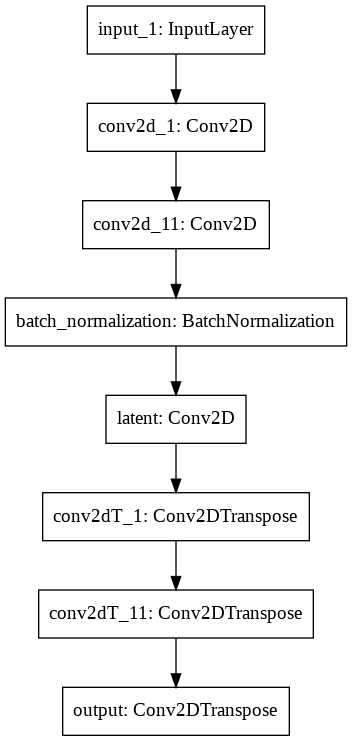

In [29]:
model_plot = tf.keras.utils.plot_model(model, to_file='model.png', dpi=96)
model_plot